# Imports required

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

#!pip install deap

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

import operator
import random

import math

Loading in CIFAR-10

In [23]:
# The dataset comes in data of the range 0-1, we want to convert this to -1 to 1 as part of normalisation

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Function to transform the dataset to the specified range

batch_size = 512

# Downloading the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Loading the training set into a variable
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# etc.
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Specifying the classes of the dataset that we want to train the classifier on
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Testing for GPU

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


Testing to see if we can see the images

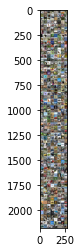

ship  horse car   dog   dog   dog   deer  bird  deer  bird  dog   ship  ship  ship  truck cat   cat   deer  frog  horse dog   cat   frog  dog   dog   frog  deer  cat   dog   plane bird  plane truck plane dog   plane cat   frog  bird  frog  cat   deer  cat   truck deer  dog   horse plane dog   bird  deer  dog   ship  car   frog  bird  cat   horse ship  frog  plane deer  deer  dog   frog  bird  dog   truck horse dog   cat   bird  cat   horse truck plane frog  horse truck cat   frog  ship  horse car   ship  bird  plane dog   bird  dog   car   truck bird  ship  dog   cat   car   bird  plane bird  frog  bird  deer  horse truck dog   ship  plane frog  bird  dog   frog  car   deer  bird  truck ship  deer  cat   truck car   horse bird  ship  cat   deer  car   bird  frog  deer  horse bird  frog  plane frog  dog   car   plane deer  cat   truck horse deer  ship  horse frog  cat   dog   deer  truck plane horse ship  bird  dog   frog  deer  deer  ship  ship  deer  car   frog  cat   plane plane plan

In [25]:
# functions to show an image for fun


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Building network definition

In [26]:
#based on VGG
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 52),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(52, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model=Net()

In [6]:
#Upload GD_Model.pth to the session to act as pre-defined network
from google.colab import files
files.upload()

Saving SGD_net.pth to SGD_net.pth


Loading in the model

In [27]:
PATH = ('./SGD_net.pth')
PopModel = Net()
PopModel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [28]:
# Setting all layers to not change their weights with GD backpropagation

for param in PopModel.parameters():
    # By setting the requires grad for each parameter to false, we no longer track it with autograd
    # Consequently, backpropagation or whatever will not compute the gradients for these layers
    param.requires_grad = False

Getting the final layer

In [29]:
#finalLayer = list(PopModel.children())[-1]

finalLayer = PopModel.classifier[-1]

print(finalLayer) # 10 features out

outerShape = len(finalLayer.weight)
innerShape = len(finalLayer.weight[0])

totalWeights = outerShape * innerShape

print(outerShape) # 10 population size
print(innerShape) # 10 arrays, with 52 items in it

# 84 inputs connected to a single output, there are 10 outputs therefore 84x10 connections in total. for one output, the 84 connections will have 84 different weights which are used
# to calculate the output node. therefore there are 10 tensors with 84 elements in each tensor, with a different set of weights.

# print(finalLayer.weight)

#print(finalLayer.weight) # Layer requires 840 connections

biasCount = len(finalLayer.bias)
print(biasCount)

paramCount = sum(param.numel() for param in finalLayer.parameters())

print(paramCount) # 530 Parameters: 520 weights + 10 biases

#sk= torch.max(((finalLayer.weight).reshape(840,)))

#print(sk)

Linear(in_features=52, out_features=10, bias=True)
10
52
10
530


In [10]:
# Randomise final layer weights



nn.init.xavier_uniform(finalLayer.weight)

#print(finalLayer.weight)

print((finalLayer.weight).shape) # Shape that the layer requires is (10,84)

print((finalLayer.bias).shape)

torch.Size([10, 52])
torch.Size([10])


<ipython-input-10-0638b396f9c2>:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(finalLayer.weight)


In [30]:
# Converting weights to a numpy array

def convert_np_function(self, intermediate_tensor):
        intermediate_value = intermediate_tensor.numpy()
        self.intermediate_values.append(intermediate_value)

populationList = finalLayer.weight.numpy()

#print(populationList) # Converted to Numpy

Defining PSO functions

In [35]:
posMinInit      = -0.1
posMaxInit      = +0.1
VMaxInit        = 1.5
VMinInit        = 0.5
#populationSize  = 3
dimension       = paramCount
populationSize  = 100+int(dimension/10) # from lab on SL-PSO
#interval        = 10
interval = 1
iterations      = 100

#variables used in SL-PSO
epsilon = dimension/100.0*0.01 # social influence of swarm centre

#Parameter setup -- these are not used in SL-PSO
wmax = 0.9 #weighting
wmin = 0.4
c1   = 2.0
c2   = 2.0

# Criterion for measuring loss, may need to tweak this to return negative value for PSO
criterion = nn.CrossEntropyLoss()

# Values used for the Gaussian Mutation
sigmaValue = 0.5
muValue = 0

# Standard deviation of the population should be below this number to start mutation
MutationStart = 1.0

lossTracker = []

accuracyTracker = []

In [36]:
# function to get the mean positions of the inviduals (swarm centre)
def getcenter(pop):
    center=list()
    for j in range(dimension): # count through dimensions
        centerj = 0
        for i in pop: # for each particle
            centerj += i[j] # sum up position in dimention j
        centerj /= populationSize # Average
        center.append(centerj)
    return center

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # -1 is for minimise
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, smin=None, smax=None, best=None)

/vol/hpc-software/software/Anaconda3/2020.07/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/vol/hpc-software/software/Anaconda3/2020.07/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [37]:
# particle rerpresented by list of 5 things
# 1. fitness of the particle,
# 2. speed of the particle which is also going to be a list,
# 3.4. limit of the speed value,
# 5. best state the particle has been in so far.

def generate(size, smin, smax):
    part = creator.Particle(random.uniform(posMinInit, posMaxInit) for _ in range(size))
    part.speed = [random.uniform(VMinInit, VMaxInit) for _ in range(size)]
    part.smin = smin #speed clamping values
    part.smax = smax
    return part

def updateParticle(part,pop,center,i):
    r1 = random.uniform(0, 1)
    r2 = random.uniform(0, 1)
    r3 = random.uniform(0, 1)

    #Randomly choose a demonstrator for particle i from any of particles 0 to i-1, the Particle i
    #updates its velocity by learning from the demonstrator and the mean position of the swarm
    demonstrator=random.choice(list(pop[0:i]))

    for j in range(dimension): # count through dimensions
        part.speed[j]=r1*part.speed[j]+r2*(demonstrator[j]-part[j])+r3*epsilon*(center[j]-part[j])
        part[j]=part[j]+part.speed[j]


# Euclidean Distance used for mutation
def euclideanDistance(ind1, ind2):
  distance = (ind1 - ind2)**2
  return math.sqrt(distance)

# Used to rescale distances between 0 and 1, with lower distances being scaled closer to 1.
def rescaler(distances):
  scaled = [1 / (d + 1) for d in distances]

  return scaled


def getBestAccuracy(bestParticle):
  bestNP = np.array(bestParticle)

  # Splitting into weights and biases
  bestWeights = bestNP[:totalWeights]
  bestBiases = bestNP[-biasCount:]

  # Putting biases in
  bestBiases = torch.from_numpy(bestBiases).float()
  finalLayer.bias = torch.nn.Parameter(bestBiases.float())

  # Reshaping weights so they are correct for the layer
  bestWeights = bestWeights.reshape(outerShape,innerShape)

  # Converting to torch array
  bestWeights = torch.from_numpy(bestWeights).float()

  # Putting the weights into the layer
  finalLayer.weight = torch.nn.Parameter(bestWeights.float())

  correct_pred = 0
  total_pred = 0

  PopModel.to(device)

  for data in trainloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = PopModel(images)

  _, predictions = torch.max(outputs, 1)

  # collect the correct predictions for each class

  for label, prediction in zip(labels, predictions):
    if label == prediction:
      correct_pred += 1
    total_pred += 1

  acc = (correct_pred / total_pred)*100


  print("Accuracy of current best particle: " + str(acc) + "%")

  return acc

In [38]:
toolbox = base.Toolbox()
toolbox.register("particle", generate, size=dimension, smin=-3, smax=3)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("update", updateParticle)

# Note most likely need to change the evaluate function
toolbox.register("evaluate", benchmarks.sphere) #sphere function is built-in in DEAP

# def sphere(individual):
#     r"""Sphere test objective function.

#     .. list-table::
#        :widths: 10 50
#        :stub-columns: 1

#        * - Type
#          - minimization
#        * - Range
#          - none
#        * - Global optima
#          - :math:`x_i = 0, \forall i \in \lbrace 1 \ldots N\rbrace`, :math:`f(\mathbf{x}) = 0`
#        * - Function
#          - :math:`f(\mathbf{x}) = \sum_{i=1}^Nx_i^2`
#     """
#     return sum(gene * gene for gene in individual), # How does this work?, return one value or return a list?

# the line above returns one value

runCounter = 0

def modelEval(particle, runCounter):
    runCounter = runCounter
    runCounter +=1
    #print("hello!")

    # First step to get the particles weights out from it, convert to an numpy array
    particleweightsNP1 = np.array(particle)

    #particleweightsNP = particleweightsNP1[:840]
    #biases = np.array(particleweightsNP1[-10:])
    particleweightsNP = particleweightsNP1[:totalWeights]
    biases = np.array(particleweightsNP1[-biasCount:])

    # Putting biases straight in
    biases = torch.from_numpy(biases).float()
    finalLayer.bias = torch.nn.Parameter(biases.float())

    #print(particleweightsNP)

#     print("Shape of particle: " + str(particleweightsNP.shape))

    # Converting to the correct shape!
    reshapedWeights = particleweightsNP.reshape(outerShape,innerShape)
#     print("Shape of reshaped particle: " + str(reshapedWeights.shape))

    # Convert to torch array!
    torchWeights = torch.from_numpy(reshapedWeights).float()

    # Now we want to set the weights of the finalLayer to these weights

    finalLayer.weight = torch.nn.Parameter(torchWeights.float())

    # print("After:\n")
    # print(finalLayer.weight)

    #finalLayer.weight.data = torchWeights.float()
    #print(finalLayer.weight) # Note that the numbers look different than torchWeights ?
    #print(torchWeights)

    # Run a training loop for the model, with the particles weights set to the final layer and return a loss value back

    epoch_loss = 0.0
    running_loss = 0.0

    # reshapedWeights.to(device)
    # torchWeights.to(device)

#     print(f"Starting training run {runCounter}...")

    PopModel.to(device)

    for epoch in range(1):

        epoch_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            # Getting the predictions for the model
            outputs = PopModel(inputs)

            loss = criterion(outputs, labels)

            #print(loss.item())

            epoch_loss += loss.item()

#         print("End of Epoch:" + str(epoch))

        running_loss += (epoch_loss / i)

    # Now we have a loss value:
    #print("Total Loss: " + str(running_loss))


    return running_loss, # This may be the wrong this to pass back, one test run showed loss is 835852, remember to check that it definitely doesnt update through gradient!

    # High loss could be due to how the weights were initialised or how they were converted between numpy and torch tensor?

    # We need to return one value

    #object of type 'NoneType' has no len() # Error when not returning anything.
    #object of type 'float' has no len() # Error when returning_loss by itself, investigate the output of the original sphere function?

    # Original loss function returns a single value. example output looks like (136.3042681576523,)

    # Do you need to return a list, with each epoch loss in there?
    # Doing this: Assigned values have not the same length than fitness weights
    # Update: Do not return a list

toolbox.register("evaluate2", modelEval)

In [39]:
def main():
    pop = toolbox.population(n=populationSize) # Population Size
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    #intialize the learning probabilities
    prob=[0]*populationSize
    for i  in range(len(pop)):
        prob[populationSize - i - 1] = 1 - i/(populationSize - 1)
        prob[populationSize - i - 1] = pow(prob[populationSize - i - 1], math.log(math.sqrt(math.ceil(dimension/100.0))))

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    # Mutation Tick, counts the number of times the swarm std deviation is below a certain amount
    MutationTick = 0

    #begin main loop
    for g in range(iterations):

        for part in pop:
            part.fitness.values = toolbox.evaluate2(part, runCounter) #actually only one fitness value

        #Sort the individuals in the swarm in ascending order. i.e., particle 0 is the best

        # sortedPop = pop

        pop.sort(key=lambda x: x.fitness, reverse=True)
        #calculate the center (mean value) of the swarm
        center = getcenter(pop)

        # Code to update particle via velocity
        for i  in reversed(range(len(pop)-1)):  # start with worst particle, and go in reverse towards best
                                                # don't do element 0 (best). Hence the i+1 below.
            if random.uniform(0, 1)<prob[i+1]: #learning probability for that particle
                toolbox.update(pop[i+1],pop,center,i+1)

        # Gather all the fitnesses in one list and print the stats
        # print every interval
        if g%interval==0: # interval
            logbookRecord = logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
            print(logbook.stream)

        avgloss = logbook.select("avg")[-1]

        # Add the average loss to the list, may not be necessary but it is useful
        lossTracker.append(avgloss)

        # Evaluate the accuracy of the current best particle

        accuracyTracker.append(getBestAccuracy(pop[0]))

        # Creating the mutation aspect
        stdev = logbook.select("std")
        # Get the latest standard deviation metric
        latestStd = stdev[-1]

        if latestStd < 1.0:
          MutationTick += 1
        else:
          MutationTick = 0

        print("Current Mutation Tick: " + str(MutationTick))

        # # Sort the population again for now.
        # sortedPop.sort(key=lambda x: x.fitness, reverse=True)

        # for i in sortedPop:
        #   print(i.fitness.values[0]) # Print out the sorted fitness values


        # print("best:"+str(pop[0].fitness.values[0]))
        # for i in pop:
        #   print(i.fitness.values[0])


        # We want to start mutation if we know the particles are starting to converge, this will be when standard deviation of the population drops below a certain value

        if MutationTick >= 3:
          print("Starting Mutation of Particles")

          # Get the best fitness value out:
          bestParticle = pop[0].fitness.values[0]

          # Calculate a list of euclidean distances
          distances = []

          # Loops through population apart from the first value as we dont need to calculate the distance for the first particle as it is already the best
          for i in pop[1:]:
            individualFitness = i.fitness.values[0]
            distances.append(euclideanDistance(bestParticle, i.fitness.values[0]))
          #print(distances)

          # Apply a function to the distance list to map them between 0 and 1, we want the smaller EDs to have a bigger probability
          # Then apply deap mutate function to the particles with their corresponding calculated probability of mutation
          probs = rescaler(distances)

          #print(probs)

          # Iterate through both population and the probability list and mutate with the probabilities
          # Important, may need to adjust the value of sigma and mu accordingly as this is gaussian distribution

          # Larger sigma = more exploration, smaller = more exploitation
          # Mu controls the bias of the spread

          # Attempting to mutate!
          for i, p in zip(pop[1:], probs):
            tools.mutGaussian(i, mu=muValue, sigma=sigmaValue, indpb=p)

          # Reset Mutation Tick
          MutationTick = 0

    return pop, logbook

if __name__ == "__main__":
    superpart = main()

gen	evals	avg    	std     	min    	max    
0  	153  	2.56043	0.129926	2.14387	2.94668
Accuracy of current best particle: 30.952380952380953%
Current Mutation Tick: 1
1  	153  	3.13181	0.995918	2.14923	6.1981 
Accuracy of current best particle: 24.702380952380953%
Current Mutation Tick: 2
2  	153  	3.19188	1.00665 	2.14349	7.38529
Accuracy of current best particle: 23.214285714285715%
Current Mutation Tick: 0
3  	153  	3.01517	0.865177	2.14467	7.96339
Accuracy of current best particle: 22.023809523809522%
Current Mutation Tick: 1
4  	153  	2.96292	0.874672	2.1304 	7.26597
Accuracy of current best particle: 26.785714285714285%
Current Mutation Tick: 2
5  	153  	2.86645	0.879718	2.12718	7.45617
Accuracy of current best particle: 24.107142857142858%
Current Mutation Tick: 3
Starting Mutation of Particles
6  	153  	7.03851	1.27969 	2.12795	11.1786
Accuracy of current best particle: 29.464285714285715%
Current Mutation Tick: 0
7  	153  	6.1878 	1.21926 	2.12719	11.5272
Accuracy of current be

66 	153  	4.10578	1.26523 	1.53002	11.1528
Accuracy of current best particle: 45.535714285714285%
Current Mutation Tick: 0
67 	153  	3.72169	1.66778 	1.52706	18.3826
Accuracy of current best particle: 50.0%
Current Mutation Tick: 0
68 	153  	3.47382	1.5181  	1.50054	12.2427
Accuracy of current best particle: 50.595238095238095%
Current Mutation Tick: 0
69 	153  	3.20654	1.40718 	1.51209	12.6417
Accuracy of current best particle: 51.488095238095234%
Current Mutation Tick: 0
70 	153  	2.96321	1.21097 	1.50086	8.17104
Accuracy of current best particle: 45.83333333333333%
Current Mutation Tick: 0
71 	153  	2.87242	1.46818 	1.50957	14.4558
Accuracy of current best particle: 47.023809523809526%
Current Mutation Tick: 0
72 	153  	2.66153	1.17673 	1.50197	9.16459
Accuracy of current best particle: 47.61904761904761%
Current Mutation Tick: 0
73 	153  	2.48142	1.01538 	1.50502	8.71359
Accuracy of current best particle: 46.42857142857143%
Current Mutation Tick: 0
74 	153  	2.27378	0.822665	1.4870

In [40]:
# Quicksave the best particle

print(len(superpart[1])) # best particle has 840 weights in it
print(superpart[1])
arr = np.array(superpart[1])

print(arr.shape)

import csv

with open('superpart-050.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerows([superpart[0][0]])

with open('logbook-050.csv', 'a', newline='') as file:
    writer = csv.writer(file)
#     writer.writerows(["gen","evals","avg","std","min","max"])
    writer.writerows([superpart[1].select("gen"),superpart[1].select("evals"),superpart[1].select("avg"),
                      superpart[1].select("std"),superpart[1].select("min"),superpart[1].select("max")])

100
gen	evals	avg    	std     	min    	max    
0  	153  	2.56043	0.129926	2.14387	2.94668
1  	153  	3.13181	0.995918	2.14923	6.1981 
2  	153  	3.19188	1.00665 	2.14349	7.38529
3  	153  	3.01517	0.865177	2.14467	7.96339
4  	153  	2.96292	0.874672	2.1304 	7.26597
5  	153  	2.86645	0.879718	2.12718	7.45617
6  	153  	7.03851	1.27969 	2.12795	11.1786
7  	153  	6.1878 	1.21926 	2.12719	11.5272
8  	153  	5.56735	1.09979 	2.13047	10.421 
9  	153  	5.05523	1.13293 	2.12903	9.32467
10 	153  	4.89468	1.38642 	2.12734	9.82982
11 	153  	4.63499	1.51414 	2.12766	11.2628
12 	153  	4.41202	1.38369 	2.12852	10.3467
13 	153  	4.21092	1.52753 	2.12516	11.4653
14 	153  	3.89161	1.15022 	2.12932	8.51362
15 	153  	3.71048	1.2558  	2.12906	11.7674
16 	153  	3.5095 	1.02199 	2.12572	9.65386
17 	153  	3.36798	0.983368	2.12559	8.74483
18 	153  	3.2358 	0.989884	2.10742	7.47864
19 	153  	3.02138	0.85531 	2.10882	6.42718
20 	153  	6.49192	1.12652 	2.10516	8.78805
21 	153  	5.6248 	1.09367 	2.10383	9.17083
22 	153

In [41]:
# Write accuracy data to csv

with open('accuracyTrack-050.csv', 'a', newline='') as file:
    newWriter = csv.writer(file)
    newWriter.writerows([accuracyTracker])

In [19]:
print(accuracyTracker)

[14.705882352941178, 16.911764705882355, 19.852941176470587, 15.073529411764705, 15.808823529411764, 16.911764705882355, 18.014705882352942, 21.691176470588236, 15.073529411764705, 16.544117647058822, 19.11764705882353, 21.323529411764707, 14.705882352941178, 22.058823529411764, 16.544117647058822, 20.955882352941178, 21.691176470588236, 21.323529411764707, 19.11764705882353, 26.47058823529412, 26.10294117647059, 27.205882352941174, 23.897058823529413, 25.0, 21.691176470588236, 21.323529411764707, 23.161764705882355, 21.323529411764707, 26.47058823529412, 21.691176470588236, 23.161764705882355, 21.691176470588236, 20.22058823529412, 20.588235294117645, 25.735294117647058, 22.794117647058822, 27.573529411764707, 27.573529411764707, 31.25, 28.308823529411764, 36.39705882352941, 29.77941176470588, 29.77941176470588, 29.044117647058826, 25.0, 29.411764705882355, 31.61764705882353, 31.985294117647058, 34.19117647058824, 36.029411764705884, 38.23529411764706, 36.029411764705884, 37.5, 38.970

In [46]:
# Put in the bestparticle like this superPart[2] (format to get the best particle after running main)
def evaluateBest(bestParticle):
  bestNP = np.array(bestParticle)

  # Splitting into weights and biases

  bestWeights = bestNP[:totalWeights]
  bestBiases = bestNP[-biasCount:]

  # Putting biases in
  bestBiases = torch.from_numpy(bestBiases).float()
  finalLayer.bias = torch.nn.Parameter(bestBiases.float())

  # Reshaping weights so they are correct for the layer
  bestWeights = bestWeights.reshape(outerShape,innerShape)

  # Converting to torch array
  bestWeights = torch.from_numpy(bestWeights).float()

  # Putting the weights into the layer

  finalLayer.weight = torch.nn.Parameter(bestWeights.float())


  # Evaluating the best particle on the test set

  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}
    
  correct = 0
  total = 0

  # Move the model onto GPU again? Most likely do not need to as it should already be in the GPU


  PopModel.to(device)  

  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = PopModel(images)

    _, predictions = torch.max(outputs, 1)

    # collect the correct predictions for each class

        
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
            correct += 1
        total_pred[classes[label]] += 1
        total += 1

  # Printing the results
  for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    raccuracy = (correct/total)*100
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
    
    return raccuracy
    
    

In [47]:
accFinal = evaluateBest(superpart[0][0])

Accuracy for class: plane is 47.1 %


In [48]:
print(accFinal)

51.54


In [52]:
f = open("accFinal.txt", "a")
f.write(str(accFinal))
f.close()